<a href="https://colab.research.google.com/github/supernova276/HybridMovieRec/blob/main/Hyrbridrec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fuzzywuzzy #used to calculate the similarity between strings

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install surprise #module for recommender systems ,provides ready touse pred algo like svd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#installing required librairies

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, SVDpp, KNNBasic
import re 
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from fuzzywuzzy import fuzz

from surprise import Dataset
from surprise.model_selection import cross_validate,train_test_split, GridSearchCV
from surprise import NormalPredictor
from surprise import Reader

from matplotlib import pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from IPython.display import display
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#exploratory data analysis

In [ ]:
movies=pd.read_csv('/content/movies.csv')
ratings=pd.read_csv('/content/ratings.csv')


In [ ]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies['title']

0                                Toy Story (1995)
1                                  Jumanji (1995)
2                         Grumpier Old Men (1995)
3                        Waiting to Exhale (1995)
4              Father of the Bride Part II (1995)
                          ...                    
9737    Black Butler: Book of the Atlantic (2017)
9738                 No Game No Life: Zero (2017)
9739                                 Flint (2017)
9740          Bungo Stray Dogs: Dead Apple (2018)
9741          Andrew Dice Clay: Dice Rules (1991)
Name: title, Length: 9742, dtype: object

In [ ]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies.shape

(9742, 3)

In [ ]:
ratings.shape

(100836, 4)

In [ ]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [ ]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [ ]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [ ]:
unq_movieIds=ratings['movieId'].unique()
print(unq_movieIds.size)

9724


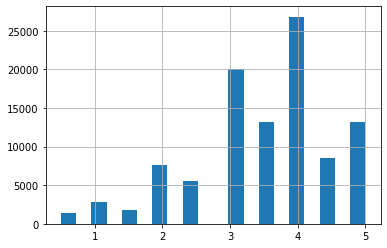

In [ ]:
ratings['rating'].hist(bins=20) #total ratins mein se 25000 ratings are equal to 5

#desgining  data maps

In [ ]:

ratings_array = ratings['rating'].unique() #stores all the unique ratings out of the ratings df
max_rating = np.amax( ratings_array )   #finding the max ratings
min_rating = np.amin( ratings_array )   #finding the min rating
print( ratings_array )                 

[4.  5.  3.  2.  1.  4.5 3.5 2.5 0.5 1.5]


In [ ]:
#converting a series to a dict
movie_map = pd.Series(movies.movieId.values,index=movies.title).to_dict() #dict{title:movieId}
#reversing the above moviemap  dict{movieId:title}
reverse_movie_map = {v: k for k, v in movie_map.items()}
#dict={movies.index:movieId}
movieId_to_index_map = pd.Series(movies.index.values,index=movies.movieId).to_dict()
#will store all the unique values for the movieId
movieId_all_array = movies['movieId'].unique()

#finding movieId of the given movie

In [ ]:
def get_movieId( movie_name ):
    """
    return the movieId which is corresponding to the movie name

    Parameters
    ----------
    movie_name: string, the name of the movie w/ or w/o the year

    Return
    ------
    the movieId
    """

    # If luckily the movie name is 100% equal to a name writen in the database,
    # then return the id corresponding to the name.
    # Or...we need to consider the similarity between strings 
    if (movie_name in movie_map):
      return movie_map[movie_name]
    else:
      similar = []
      for title, movie_id in movie_map.items():
        ratio = fuzz.ratio(title.lower(), movie_name.lower())
        if ( ratio >= 60):
          similar.append( (title, movie_id, ratio ) ) #storing all the strings with similarity ratio>60
      if (len(similar) == 0):
        print("Oh! This movie does not exist in the database.")
      else:
        match_item = sorted( similar , key=lambda x: x[2] )[::-1]
        print( "The matched item might be:", match_item[0][0], ", ratio=",match_item[0][2] )
        return match_item[0][1]

#content based filtering with pairwise tfidf approach

In [ ]:
def tokenizer(text):
  lemmatizer=WordNetLemmatizer()
  torkenized = [lemmatizer.lemmatize(word).lower() for word in text.split('|') if word not in stopwords.words('english')]
  return torkenized

In [ ]:
tfid=TfidfVectorizer(analyzer='word', tokenizer=tokenizer)

In [ ]:
tfidf_matrix = tfid.fit_transform(movies['genres'])

In [ ]:
cos_sim = cosine_similarity(tfidf_matrix,tfidf_matrix)

In [ ]:
print(tfidf_matrix.shape)
print(cos_sim.shape)
print(movies.shape)

(9742, 20)
(9742, 9742)
(9742, 3)


In [ ]:
print(cos_sim[3])
print("\nhello\n")
cos_sim_scores=list(enumerate(cos_sim[3]))
print(cos_sim_scores)

[0.1351353  0.         0.8845714  ... 0.4664048  0.         0.50501544]

hello

[(0, 0.13513530228521914), (1, 0.0), (2, 0.8845713988516402), (3, 1.0), (4, 0.5050154397005037), (5, 0.0), (6, 0.8845713988516402), (7, 0.0), (8, 0.0), (9, 0.0), (10, 1.0), (11, 0.25733057159885575), (12, 0.0), (13, 0.46640480307738325), (14, 0.41386791540689327), (15, 0.23487691294360039), (16, 0.863110309093865), (17, 0.5050154397005037), (18, 0.5050154397005037), (19, 0.32960684193624074), (20, 0.21866343162925583), (21, 0.12493028209483505), (22, 0.0), (23, 0.22390766139708893), (24, 0.863110309093865), (25, 0.46640480307738325), (26, 0.20506063431314472), (27, 0.863110309093865), (28, 0.11840167302822738), (29, 0.23487691294360039), (30, 0.46640480307738325), (31, 0.0), (32, 0.20506063431314472), (33, 0.23487691294360039), (34, 0.23650819876873833), (35, 0.8845713988516402), (36, 0.46640480307738325), (37, 0.18270473677057544), (38, 0.1882380394149203), (39, 0.46640480307738325), (40, 0.0), (41, 0.4880

#SVD matrix factorization model in collaborative filtering

In [ ]:


#Before we proceed to the modeling part, we need to convert our dataset into a Dataset object from the Surprise library.
# In order to do this, we need to define a Reader object to be able to parse the DataFrame. We also need to follow this
# specific column order: user ID, item ID, and rating.

features=['userId','movieId','rating']
reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(ratings[features], reader)

#hyperparameter tuning using grdisearachcv
#hyperparameter tuning is for finding out the most optimal parameters for a learning algorithm
#It runs through all the different parameters that is fed into the parameter grid and produces the best combination
# of parameters, based on a scoring metric of your choice
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

#estimator: estimator object being used
#param_grid: dictionary that contains all of the parameters to try
#scoring: evaluation metric to use when ranking results
#cv: cross-validation, the number of cv folds for each combination of parameters
#metrics used for evaluation is root mean square and mean absolute error
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

In [ ]:
gs.fit(data)

In [ ]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8941370314897473
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [ ]:
print(gs.best_score['mae'])
print(gs.best_params['mae'])

0.6922187077764345
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [ ]:
#fitting the model over the whole dataset instead of cross validating the model
best_params = gs.best_params['rmse']
model_svd = gs.best_estimator['rmse']
model_svd.fit(data.build_full_trainset())  #training the model on the data_trainset

#getting actual ratings from predictions

In [ ]:
def get_rating_from_prediction( prediction, ratings_array ):
    """
    return the closest rating number to the prediction value

    Parameters
    ----------
    prediction: float, the prediction value from the model

    ratings_array: the 1D array of the discrete rating number

    Return
    ------
    the rating number corresponding to the prediction value
    """
    rating = ratings_array[ np.argmin( [ np.abs(item - prediction) for item in ratings_array ] ) ]
    return rating

In [ ]:
prediction = model_svd.predict(1,1)
print("rating", ratings[(ratings.userId ==1 ) & (ratings.movieId ==1 ) ]['rating']  )
print("prediction",prediction.est)

rating 0    4.0
Name: rating, dtype: float64
prediction 4.379877964482093


#make movie recommendation item based

In [ ]:
def make_recommendation_item_based( similarity_matrix ,movieId_all_array, ratings_data, id_to_movie_map, 
                                   movieId_to_index_map, fav_movie_list, n_recommendations, userId=-99):
    """
    return top n movie recommendation based on user's input list of favorite movies
    Currently, fav_movie_list only support one input favorate movie

    Parameters
    ----------
    similarity_matrix: 2d array, the pairwise similarity matrix

    movieId_all_array: 1d array, the array of all movie Id

    ratings_data: ratings data

    id_to_movie_map: the map from movieId to movie title

    movieId_to_index_map: the map from movieId to the index of the movie dataframe

    fav_movie_list: list, user's list of favorite movies

    n_recommendations: int, top n recommendations

    userId: int optional (default=-99), the user Id
            if userId = -99, the new user will be created
            if userId = -1, the latest inserted user is chosen

    Return
    ------
    list of top n movie recommendations

    """

    if (userId == -99):
      userId = np.amax( ratings_data['userId'].unique() ) + 1
    elif (userId == -1):
      userId = np.amax( ratings_data['userId'].unique() )
   
   #to store the id of all the movies that are currently in fav movielist
    movieId_list = []
    for movie_name in fav_movie_list:
      movieId_list.append( get_movieId(movie_name) )    

    # Get the movie id which is corresponding to the movie the user didn't watch before

    #creat a list of all the unique movieIds corresponding to our particulr user
    movieId_user_exist = list( ratings_data[ ratings_data.userId==userId ]['movieId'].unique() )

    #add teh previous movies where the user exists to 
    movieId_user_exist = movieId_user_exist + movieId_list
    movieId_input = []

    # if a particular movie the user has not watched, we append the movieid in movieId.input
    for movieId in movieId_all_array:
      if (movieId not in movieId_user_exist):
         movieId_input.append( movieId )

     #we find the index of the first movie in the movieId_to_index_map
    index = movieId_to_index_map[movieId_list[0]]

    #
    cos_sim_scores=list(enumerate(similarity_matrix[index]))
    cos_sim_scores=sorted(cos_sim_scores,key=lambda x:x[1],reverse=True) 

   #to store the index of the top movies
    topn_movieIndex = []
    icount = 0

    #traversing the similarity matrix

    #we find the index of all the movies the user has not watched yet and append the cosine similarity  corresponding to those indexes to the resultant list
    for i in range(len(cos_sim_scores)):
      if( cos_sim_scores[i][0] in [movieId_to_index_map[ids] for ids in movieId_input ]  ):
        icount += 1
        topn_movieIndex.append( cos_sim_scores[i][0] )
        #if we have found the top n recommendatins we will break
        if( icount == n_recommendations ):
          break
    
    topn_movie = [ movies.loc[index].title for index in topn_movieIndex ]
    return topn_movie

#movie recommendation using user based approach

In [ ]:
def make_recommendation_user_based(best_model_params, movieId_all_array, ratings_data, id_to_movie_map,
                        fav_movie_list, n_recommendations, userId=-99 ):
    """
    return top n movie recommendation based on user's input list of favorite movies
    Currently, fav_movie_list only support one input favorate movie


    Parameters
    ----------
    best_model_params: dict, {'iterations': iter, 'rank': rank, 'lambda_': reg}

    movieId_all_array: the array of all movie Id

    ratings_data: ratings data

    id_to_movie_map: the map from movieId to movie title

    fav_movie_list: list, user's list of favorite movies

    n_recommendations: int, top n recommendations

    userId: int optional (default=-99), the user Id
            if userId = -99, the new user will be created
            if userId = -1, the latest inserted user is chosen

    Return
    ------
    list of top n movie recommendations
    """
    movieId_list = []
    for movie_name in fav_movie_list:
      movieId_list.append( get_movieId(movie_name) )

    if (userId == -99):
      userId = np.amax( ratings_data['userId'].unique() ) + 1
    elif (userId == -1):
      userId = np.amax( ratings_data['userId'].unique() )

    ratings_array = ratings['rating'].unique()
    max_rating = np.amax( ratings_array )
    min_rating = np.amin( ratings_array )

    
    # create a new trainset by adding the movies in the fav list into the previous ratings list
    user_rows = [[userId, movieId, max_rating] for movieId in movieId_list]
    df = pd.DataFrame(user_rows, columns =['userId', 'movieId', 'rating']) 
    train_data = pd.concat([ratings_data, df], ignore_index=True, sort=False)

    # Get the movie id corresponding to the movie the user didn't watch before
    movieId_user_exist = train_data[ train_data.userId==userId ]['movieId'].unique()
    movieId_input = []
    for movieId in movieId_all_array:
      if (movieId not in movieId_user_exist):
         movieId_input.append( movieId )
    
  
    reader = Reader(rating_scale=(min_rating, max_rating))
#loading the new dataset with a new user into the  dataset object
    data = Dataset.load_from_df(train_data, reader)

#training the model on the new trainset with a new user and previous set of best params generated.
    model = SVD(**best_model_params)
    model.fit(data.build_full_trainset())

#store the prediction for ratings given for all the movies the user has not watched yet
    predictions = []
    for movieId in movieId_input:
      predictions.append( model.predict(userId,movieId) )

    #sort the estimated ratings in reverse order
    sort_index = sorted(range(len(predictions)), key=lambda k: predictions[k].est, reverse=True)

    topn_predictions = [ predictions[i].est for i in sort_index[0:min(n_recommendations,len(predictions))] ]
    topn_movieIds = [ movieId_input[i] for i in sort_index[0:min(n_recommendations,len(predictions))] ]
    topn_rating = [ get_rating_from_prediction( pre, ratings_array ) for pre in topn_predictions ]

    topn_movie = [ id_to_movie_map[ ids ] for ids in topn_movieIds ]
    return topn_movie

#make a movie recommendation

In [ ]:
my_favorite_movies = ['Othello']

# get recommends
n_recommendations = 10

recommends_item_based = make_recommendation_item_based( 
    similarity_matrix = cos_sim,
    movieId_all_array = movieId_all_array,
    ratings_data = ratings[features], 
    id_to_movie_map = reverse_movie_map, 
    movieId_to_index_map = movieId_to_index_map,
    fav_movie_list = my_favorite_movies, 
    n_recommendations = n_recommendations)

recommends_user_based = make_recommendation_user_based(
    best_model_params = best_params, 
    movieId_all_array = movieId_all_array,
    ratings_data = ratings[features], 
    id_to_movie_map = reverse_movie_map, 
    fav_movie_list = my_favorite_movies, 
    n_recommendations = n_recommendations)

print("-------------Search based on item's content similarity--------------------")
print('The movies similar to' , my_favorite_movies , ':' )
for i, title in enumerate(recommends_item_based):
    print(i+1, title)  
if( len(recommends_item_based) < n_recommendations ):
  print("Sadly, we couldn't offer so many recommendations :(")    

print("--------------Search based on similarity between user's preference--------------------------------------")
print('The users like' , my_favorite_movies , 'also like:')
for i, title in enumerate(recommends_user_based):
    print(i+1, title)
if( len(recommends_user_based) < n_recommendations ):
  print("Sadly, we couldn't offer so many recommendations :(")

The matched item might be: Othello (1995) , ratio= 67
The matched item might be: Othello (1995) , ratio= 67
-------------Search based on item's content similarity--------------------
The movies similar to ['Othello'] :
1 Nixon (1995)
2 Dangerous Minds (1995)
3 Cry, the Beloved Country (1995)
4 Restoration (1995)
5 Georgia (1995)
6 Home for the Holidays (1995)
7 Mr. Holland's Opus (1995)
8 Boys of St. Vincent, The (1992)
9 Basketball Diaries, The (1995)
10 Awfully Big Adventure, An (1995)
--------------Search based on similarity between user's preference--------------------------------------
The users like ['Othello'] also like:
1 Shawshank Redemption, The (1994)
2 Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
3 Godfather, The (1972)
4 Rear Window (1954)
5 Lawrence of Arabia (1962)
6 Fight Club (1999)
7 Pulp Fiction (1994)
8 In the Name of the Father (1993)
9 Goodfellas (1990)
10 Apocalypse Now (1979)


#creating the database

In [ ]:
#function returning the resultant movie list
def findMovie(currMovie):
    my_favorite_movies = [currMovie]

    #get recommends item based
    recommends_item_based = make_recommendation_item_based( 
    similarity_matrix = cos_sim,
    movieId_all_array = movieId_all_array,
    ratings_data = ratings[features], 
    id_to_movie_map = reverse_movie_map, 
    movieId_to_index_map = movieId_to_index_map,
    fav_movie_list = my_favorite_movies, 
    n_recommendations = n_recommendations)

    # get recommends user based
    ''' n_recommendations = 10
    recommends_user_based = make_recommendation_user_based(
    best_model_params = best_params, 
    movieId_all_array = movieId_all_array,
    ratings_data = ratings[features], 
    id_to_movie_map = reverse_movie_map, 
    fav_movie_list = my_favorite_movies, 
    n_recommendations = n_recommendations)'''

    return recommends_item_based

In [ ]:
#storing the resultant list corrersponding to every movie in a dataframe
resultDataframe=pd.DataFrame()
for i in movies['title'][:10]:
  col=findMovie(i)
  tempDataframe=pd.DataFrame(col,columns=[i])
  resultDataframe=pd.concat([resultDataframe,tempDataframe],axis=1)
display(resultDataframe)

,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995)
0,Antz (1998),"Indian in the Cupboard, The (1995)",Sabrina (1995),"American President, The (1995)",Four Rooms (1995),Assassins (1995),Grumpier Old Men (1995),"Amazing Panda Adventure, The (1995)",Fair Game (1995),Broken Arrow (1996)
1,Toy Story 2 (1999),"NeverEnding Story III, The (1994)",Clueless (1995),Mighty Aphrodite (1995),Ace Ventura: When Nature Calls (1995),Die Hard: With a Vengeance (1995),Clueless (1995),Casper (1995),Under Siege 2: Dark Territory (1995),Cliffhanger (1993)
2,"Adventures of Rocky and Bullwinkle, The (2000)",Escape to Witch Mountain (1975),Two if by Sea (1996),"Postman, The (Postino, Il) (1994)",Bio-Dome (1996),"Net, The (1995)",Two if by Sea (1996),Far From Home: The Adventures of Yellow Dog (1...,"Hunted, The (1995)",Executive Decision (1996)
3,"Emperor's New Groove, The (2000)",Darby O'Gill and the Little People (1959),French Twist (Gazon maudit) (1995),Beautiful Girls (1996),Friday (1995),Natural Born Killers (1994),French Twist (Gazon maudit) (1995),Lassie (1994),Bloodsport 2 (a.k.a. Bloodsport II: The Next K...,Surviving the Game (1994)
4,"Monsters, Inc. (2001)",Return to Oz (1985),If Lucy Fell (1996),Something to Talk About (1995),Black Sheep (1996),Judgment Night (1993),If Lucy Fell (1996),Homeward Bound II: Lost in San Francisco (1996),Best of the Best 3: No Turning Back (1995),"Rock, The (1996)"
5,"Wild, The (2006)","NeverEnding Story, The (1984)",Boomerang (1992),Don Juan DeMarco (1995),Mr. Wrong (1996),Batman (1989),Boomerang (1992),Flipper (1996),Double Team (1997),Chain Reaction (1996)
6,Shrek the Third (2007),"NeverEnding Story II: The Next Chapter, The (1...",Pie in the Sky (1996),Eat Drink Man Woman (Yin shi nan nu) (1994),Happy Gilmore (1996),Die Hard (1988),Pie in the Sky (1996),Alaska (1996),Steel (1997),Maximum Risk (1996)
7,"Tale of Despereaux, The (2008)",Santa Claus: The Movie (1985),Mallrats (1995),Nobody's Fool (1994),"Steal Big, Steal Little (1995)",Hard Rain (1998),Mallrats (1995),"Adventures of Pinocchio, The (1996)",Knock Off (1998),Die Hard 2 (1990)
8,Asterix and the Vikings (Astérix et les Viking...,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Nine Months (1995),"Corrina, Corrina (1994)",Flirting With Disaster (1996),"Replacement Killers, The (1998)",Nine Months (1995),Fly Away Home (1996),Avalanche (1978),Anaconda (1997)
9,Turbo (2013),"Chronicles of Narnia: The Lion, the Witch and ...",Forget Paris (1995),I Like It Like That (1994),Down Periscope (1996),U.S. Marshals (1998),Forget Paris (1995),Swiss Family Robinson (1960),Aces: Iron Eagle III (1992),Con Air (1997)


#converting the dataframe into a csv file

In [ ]:
#converting the dataframe into a csv file
resultDataframe.to_csv('movie_similarity.csv',index=False)
! ls

movies.csv  movie_similarity.csv  ratings.csv  sample_data


In [ ]:
resultDataframe.head()

,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995)
0,Antz (1998),"Indian in the Cupboard, The (1995)",Sabrina (1995),"American President, The (1995)",Four Rooms (1995),Assassins (1995),Grumpier Old Men (1995),"Amazing Panda Adventure, The (1995)",Fair Game (1995),Broken Arrow (1996)
1,Toy Story 2 (1999),"NeverEnding Story III, The (1994)",Clueless (1995),Mighty Aphrodite (1995),Ace Ventura: When Nature Calls (1995),Die Hard: With a Vengeance (1995),Clueless (1995),Casper (1995),Under Siege 2: Dark Territory (1995),Cliffhanger (1993)
2,"Adventures of Rocky and Bullwinkle, The (2000)",Escape to Witch Mountain (1975),Two if by Sea (1996),"Postman, The (Postino, Il) (1994)",Bio-Dome (1996),"Net, The (1995)",Two if by Sea (1996),Far From Home: The Adventures of Yellow Dog (1...,"Hunted, The (1995)",Executive Decision (1996)
3,"Emperor's New Groove, The (2000)",Darby O'Gill and the Little People (1959),French Twist (Gazon maudit) (1995),Beautiful Girls (1996),Friday (1995),Natural Born Killers (1994),French Twist (Gazon maudit) (1995),Lassie (1994),Bloodsport 2 (a.k.a. Bloodsport II: The Next K...,Surviving the Game (1994)
4,"Monsters, Inc. (2001)",Return to Oz (1985),If Lucy Fell (1996),Something to Talk About (1995),Black Sheep (1996),Judgment Night (1993),If Lucy Fell (1996),Homeward Bound II: Lost in San Francisco (1996),Best of the Best 3: No Turning Back (1995),"Rock, The (1996)"
